# Model comparison

This notebook shows how deviance information criteria (DIC) can be calculated within PINTS and be used to do model comparison.

## Generate data using logistic model with Student t noise

In [9]:
import os
os.chdir("../")
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 20)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 1
values = org_values + scipy.stats.t.rvs(1.8, 0, 1, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

## Fit model A: logistic model with Gaussian noise (different model to that used to generate data)

Running...
Done!
R-hat:
[1.0000465129494469, 1.0001635197072243, 1.002055542947353]


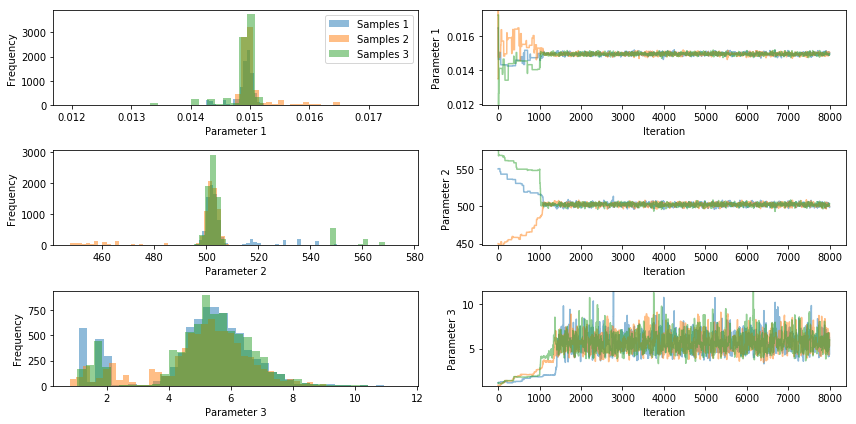

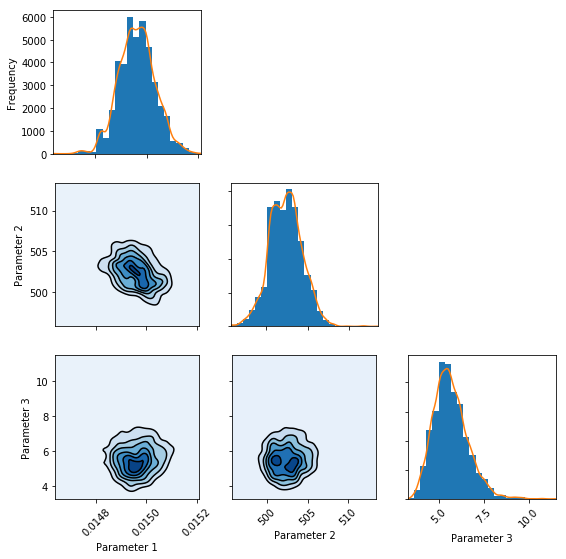

In [10]:
# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Turn on log-likelihood recording
mcmc.set_log_likelihood_storage(True)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Extract log-likelihood values
log_likelihood_gaussian = mcmc.stored_log_likelihood()

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_gaussian = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

## Fit model B: logistic model with Student-t noise (same model as used to generate data)

Running...
Done!
R-hat:
[1.001308198136535, 1.0009082701760184, 1.0017537664996985, 1.0022798359374658]


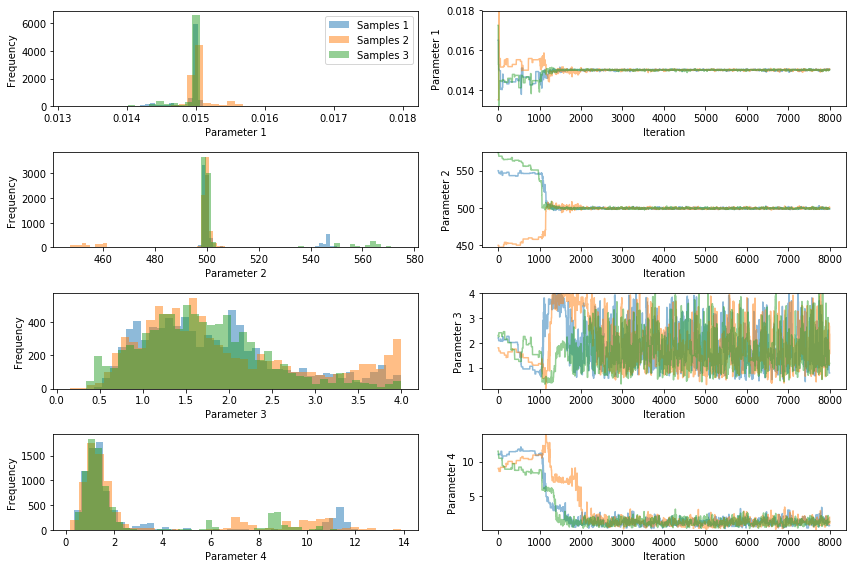

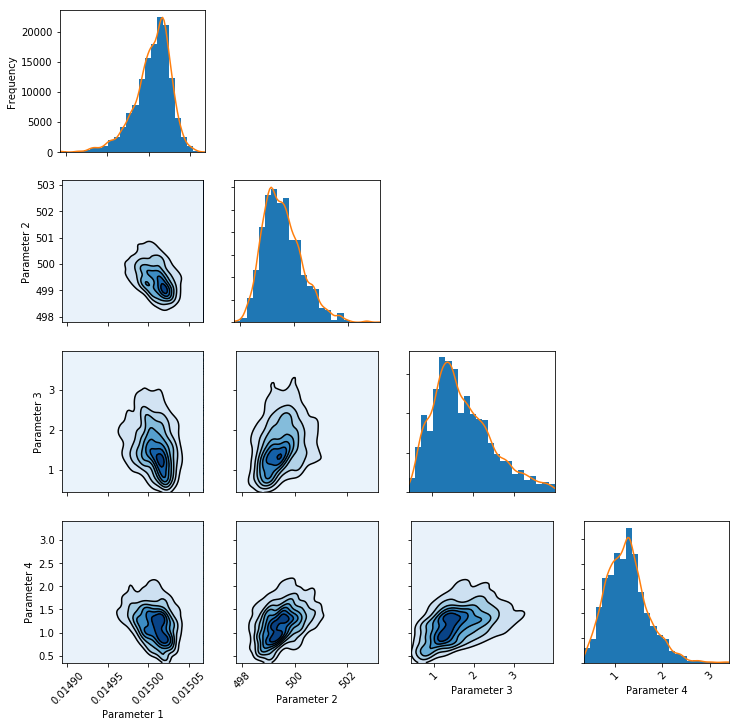

In [11]:
# Create a log-likelihood function (adds extra parameters)
log_likelihood = pints.StudentTLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, noise*0.1],
    [0.02, 600, 4, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array([0.015, 500, 2, 10])
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Turn on log-likelihood recording
mcmc.set_log_likelihood_storage(True)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Extract log-likelihood values
log_likelihood_student_t = mcmc.stored_log_likelihood()

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]
chains_student_t = chains

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

## Use log-likelihood from each model fits to calculate Deviance Information Criteria

In [12]:
# calculate posterior means of parameters
chains_gaussian1 = np.reshape(chains_gaussian, (18000, 3))
chains_student_t1 = np.reshape(chains_student_t, (18000, 4))
mean_gaussian = np.mean(chains_gaussian1, axis=0)
mean_student_t = np.mean(chains_student_t1, axis=0)

# calculate log-likelihood at posterior means
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)
log_likelihood_gaussian_mean = log_likelihood(mean_gaussian)
log_likelihood = pints.StudentTLogLikelihood(problem)
log_likelihood_student_t_mean = log_likelihood(mean_student_t)


# remove warm-up
log_likelihood_gaussian1 = log_likelihood_gaussian[4000:, :]
log_likelihood_gaussian1 = log_likelihood_gaussian1.ravel(order='F')
log_likelihood_student_t1 = log_likelihood_student_t[4000:, :]
log_likelihood_student_t1 = log_likelihood_student_t1.ravel(order='F')

# k_dic
k_dic_gaussian = 2 * np.var(log_likelihood_gaussian1)
k_dic_student_t = 2 * np.var(log_likelihood_student_t1)

# DICs
dic_gaussian = log_likelihood_gaussian_mean - k_dic_gaussian
dic_student_t = log_likelihood_student_t_mean - k_dic_student_t

As desired prefer Student t model under DIC since this model has lowest value of this metric.

In [13]:
print('Gaussian model DIC: ' + str(dic_gaussian))
print('Student t model DIC: ' + str(dic_student_t))

Gaussian model DIC: -64.2226744208
Student t model DIC: -50.6338970751
